In [1]:
import urllib
import bz2
import os
import numpy as np

In [2]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/ladybug/"
FILE_NAME = "problem-49-7776-pre.txt.bz2"
URL = BASE_URL + FILE_NAME

In [3]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

In [4]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

# load data

![](toy_ba.png)

In [6]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [7]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 49
n_points: 7776
Total number of parameters: 23769
Total number of residuals: 63686


In [24]:
print('camera_params: ',camera_params.shape)
print('points_3d: ',points_3d.shape)
print('observations: ',camera_indices.shape)
print('points_2d: ',points_2d.shape)

camera_params:  (49, 9)
points_3d:  (7776, 3)
observations:  (31843,)
points_2d:  (31843, 2)


# initial residual

In [8]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

In [9]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    # rotate
    points_proj = rotate(points, camera_params[:, :3])
    
    # translate
    points_proj += camera_params[:, 3:6]
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(points_proj**2, axis=1)
    r = 1 + k1 * n + k2 * n**2
    points_proj *= (r * f)[:, np.newaxis]
    return points_proj

In [10]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

In [27]:
from scipy.sparse import lil_matrix #Row-based linked list sparse matrix

In [12]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    '''
    Defines the sparsity structure of the Jacobian matrix for finite difference estimation,
    '''
    m = camera_indices.size * 2
    n = n_cameras * 9 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1

    return A

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

In [40]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel())) # initial values for cameras params. and 3D points

In [15]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

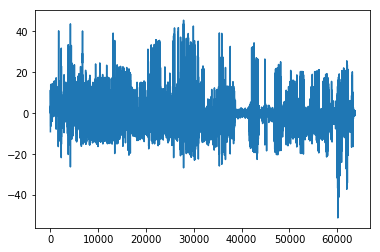

In [16]:
plt.plot(f0)

In [17]:
# jacobian sparsity matrix
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

In [26]:
A.shape

(63686, 23769)

In [33]:
import time
from scipy.optimize import least_squares # non-linear LS solve

In [41]:
t0 = time.time()
res = least_squares(fun, x0,jac='3-point',jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5091e+05                                    8.57e+06    
       1              3         5.0985e+04      8.00e+05       1.46e+02       1.15e+06    
       2              4         1.6077e+04      3.49e+04       2.59e+01       2.43e+05    
       3              5         1.4163e+04      1.91e+03       2.86e+02       1.21e+05    
       4              7         1.3695e+04      4.67e+02       1.32e+02       2.51e+04    
       5              8         1.3481e+04      2.14e+02       2.24e+02       1.54e+04    
       6              9         1.3436e+04      4.55e+01       3.18e+02       2.73e+04    
       7             10         1.3422e+04      1.37e+01       6.80e+01       2.19e+03    
       8             11         1.3418e+04      3.70e+00       1.29e+02       7.96e+03    
       9             12         1.3414e+04      4.23e+00       2.63e+01       6.19e+02    

In [42]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 27 seconds


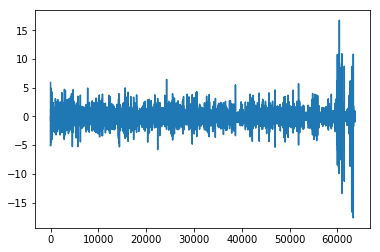

In [43]:
plt.plot(res.fun)

In [44]:
res

 active_mask: array([0., 0., 0., ..., 0., 0., 0.])
        cost: 13408.944343318137
         fun: array([ 5.89763655e+00,  2.95944686e-01,  2.95611990e+00, ...,
        2.60454624e-01, -5.09128706e-03, -2.34952349e-01])
        grad: array([-9.46651428e+01,  1.26897060e+02, -9.55105879e+00, ...,
        2.48598275e-02,  1.64201249e-02, -1.61740008e-02])
         jac: <63686x23769 sparse matrix of type '<class 'numpy.float64'>'
	with 764232 stored elements in Compressed Sparse Row format>
     message: '`ftol` termination condition is satisfied.'
        nfev: 15
        njev: 13
  optimality: 1320.3145801368144
      status: 2
     success: True
           x: array([ 0.01764225, -0.00593724, -0.00797117, ..., -0.81125291,
        0.04386668, -4.84839441])

In [45]:
res.x.shape

(23769,)

In [46]:
x0.shape

(23769,)

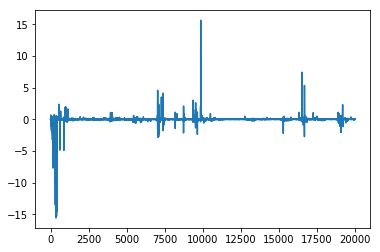

In [39]:
plt.plot((res.x-x0)[:20000])

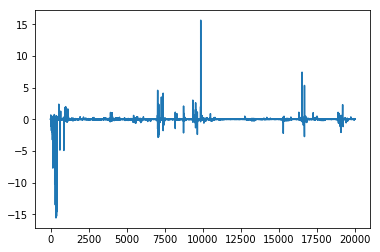

In [47]:
plt.plot((res.x-x0)[:20000])